# Earthquake Data Analysis

The project consists of analyzing a dataset (called also "catalog") of earthquakes collected in about 20 years of recording in South California.

The catalog includes the magnitude, time of occurrence (s), and 3D coordinates (m) of earthquakes. Coordinates were converted from latitude, longitude, and depth of events in a seismic catalog. Magnitudes should be within the range $[0,8]$.

* __Waiting time (t)__: time interval between an event and the next one in the sequence.
* __Distance (r)__: Euclidean 3D distance between events (each 3D set of coordinates refers to the hypocenter, i.e. the point triggering the slip in a fault that forms the earthquake).

## Data

The catalog `SouthCalifornia-1982-2011.dat` is a data file with the following content:

* column 1: index of the event
* column 2: index of the previous event that triggered it (defined with a given algorithm), -1 if no ancestor is found
* column 3: time (seconds) from 0:00 of Jan.1st, 1982
* column 4: magnitude
* columns 5, 6, and 7: 3D coordinates (in meters) of the earthquake hypocenter, i.e. of the point from where it started. These Euclidean coordinates are derived from latitude, longitude and depth.

By joining each event to that with the index of the second column (if not -1), a set of causal trees would emerge.


## Assignments

1. Visualize the process in space and/or time with a suitable time series and/or 3D visualizations of the hypocenters. For instance, plot a space variable (a single coordinate or an appropriate linear combination of coordinates) as a function of time.
2. Compute the distribution $P_m(t)$ of waiting times for events of magnitude $m$ or above (i.e. do not consider events below $m$). In shaping the bin sizes, take into account that this distribution is expected to have a power-law decay with time (e.g $\sim 1/t$), and that a power-law is well visualized in log-log scale. Do this analysis for many values of $m$, say $m=2,3,4,5$. If deemed appropriate, choose a function and fit it to the data.
3. Compute the distribution $P_m(r)$ of the distance between an event and the next one, considering earthquakes of magnitude $m$ or above. Make a clever choice for the bin sizes, and try several values of $m$. Fit the data with an appropriate function, if possible.
4. Compute the distribution $P_{m,R}(t)$ of waiting times for events of magnitude $m$ or above, which are separated by at most a distance $r<R$, for different values of m and $R$. In this case, if the following event is farther than $R$, skip the $t$ and go to the next pair.
5. Comment whether there is a scaling law from the analysis of the previous points. Is there a suitable rescaling that collapses distributions for various $m$ (and eventually $R$ if point 4 is considered) on a single curve?

## Solution

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import cartopy.crs as crs
import cartopy.feature as cfeature

## Part 1 - Visualization

In [2]:
#reading the data file with pandas
filename = "SouthCalifornia-1982-2011.dat"
columns = ["Previous event", "Time", "Magnitude", "X", "Y", "Z"]
df = pd.read_table(filename, sep=' ', header=None, names=columns)
df

,Previous event,Time,Magnitude,X,Y,Z
0,-1,0.000000e+00,2.71,-2571956,-4627162,3520602
1,0,3.650139e+04,2.12,-2363740,-4787011,3461373
2,0,3.748828e+04,2.33,-2363746,-4786942,3461232
3,0,4.798252e+04,2.57,-2475085,-4664024,3548479
4,0,6.026857e+04,2.98,-2238642,-4839098,3469546
...,...,...,...,...,...,...
110266,-1,9.304996e+08,2.60,-2668492,-4335735,3810743
110267,-1,9.305115e+08,2.02,-2297480,-4823870,3445285
110268,-1,9.305318e+08,2.00,-2404797,-4441247,3868121
110269,-1,9.305363e+08,2.17,-2388375,-4691191,3550903


The data file contains the coordinates of the hypocenter of each earthquake. From them, it is possible to retrieve the geographical coordinates (i.e. latitude, longitude and height/depth) by applying some formulas, reported in the following lines. 

The Earth is considered as an ellissoid of revolution with the following parameters:
* $a = 6378137$ m (semi-major axis of the ellipsoid)
* $b = 6356752.3142$ m (semi-minor axis of the ellipsoid)
* $f = 1/298.257223563$ (flattening f of the ellipsoid)

They are referred to the WGS84 ellipsoid, used for GPS coordinates and the most common one.

The longitude $\lambda$ and the height $h$ can be computed by applying the following formulas:

$\lambda = tan^{-1}\,{\dfrac{Y}{X}}$

and

$h = \dfrac{p}{\cos(φ)} - v$

where $p = \sqrt{X^{2} + Y^{2}}\,\,$, $\,\,\,\,v = \dfrac{a}{\sqrt{e^{2} - \sin^\,2\,(\,φ\,)}}\,\,\,\,$ and
$\,\,\,\,e^2 = f\,(2\,-\,f)\,$.

The computation of the latitude φ (needed also to compute the height) is instead much more complex.
Different solutions have been introduced during the years. The formula utilized in this notebook has been introduced by Bowring in 1976:   

$φ = \dfrac{Z\,+\,b\,e\,'\,^2\,sin^3(ψ)}{p\,-\,a\,e^2\,cos\,^3\,(\,ψ\,)}\,\,\,\,$ where 
$\,\,\,\,e\,'\,^2 = \dfrac{e\,^2}{1\,-\,e\,^2}\,\,\,\,$ and $\,\,\,\,ψ = tan^{-1}\,{\dfrac{a\,Z}{b\,p}}\,$.

In principle this should be an iterative formula, but Bowring showed that the error introduced by utilizing a single iteration is 0.000 000 030′′, so this can be considered as a closed formula.

Thanks to these formulas, taken from a paper written by Gerdan and Deakin in 1999, the original dataset has been completed with the geographical coordinates of each hypocenter.

ResearchGate link to the article: https://www.researchgate.net/publication/254250446_Transforming_cartesian_coordinates_X_Y_Z_to_geographical_coordinates_h

In [3]:
#computing latitude, longitude and depth starting from cartesian coordinates
df_complete = df.copy()

#Parameters of ellissoid WGS84
a = 6378137
b = 6356752.3142
f = 0.0033528106647474805

def rad2deg(x):
    return x*180/math.pi

def cartesian2geographic(x,y,z):
    #needed parameters
    p = np.sqrt(x**2 + y**2)
    e_squared = f*(2 - f)
    e_prime_squared = (a**2 - b**2)/b**2
    theta = np.arctan2((z*a),(p*b))
    #latitude, longitude and depth
    longitude = rad2deg(np.arctan2(y,x))
    latitude_rad = np.arctan2((z + e_prime_squared*b*(np.sin(theta))**3),(p - e_squared*a*(np.cos(theta))**3))
    latitude = rad2deg(latitude_rad) 
    v = a / np.sqrt(1 - e_squared*(np.sin(latitude_rad))**2)
    depth = p / np.cos(latitude_rad) - v 
    return longitude, latitude, depth

df_complete['Longitude'], df_complete['Latitude'], df_complete['Depth'] = cartesian2geographic(df['X'],df['Y'],df['Z'])
df_complete

,Previous event,Time,Magnitude,X,Y,Z,Longitude,Latitude,Depth
0,-1,0.000000e+00,2.71,-2571956,-4627162,3520602,-119.067002,33.803070,-13866.339234
1,0,3.650139e+04,2.12,-2363740,-4787011,3461373,-116.279332,33.133255,-9094.154533
2,0,3.748828e+04,2.33,-2363746,-4786942,3461232,-116.279718,33.132481,-9220.807083
3,0,4.798252e+04,2.57,-2475085,-4664024,3548479,-117.953814,34.081790,-9788.561405
4,0,6.026857e+04,2.98,-2238642,-4839098,3469546,-114.825995,33.229464,-10453.018614
...,...,...,...,...,...,...,...,...,...
110266,-1,9.304996e+08,2.60,-2668492,-4335735,3810743,-121.610832,37.000291,-11092.891158
110267,-1,9.305115e+08,2.02,-2297480,-4823870,3445285,-115.467209,32.990515,-14309.251611
110268,-1,9.305318e+08,2.00,-2404797,-4441247,3868121,-118.434166,37.634193,-8595.471367
110269,-1,9.305363e+08,2.17,-2388375,-4691191,3550903,-116.981514,34.180503,-21582.249468


In order to plot the coordinates of the hypocenters in a geographic map, the library cartopy has been used, that is highly compatible with matplotlib. The locations plotted in the map show the area of interest for the earthquakes, that is the californian area near Los Angeles, as expected from the dataset information, where the South California area was mentioned.

The location of Los Angeles was plotted just for comparison.

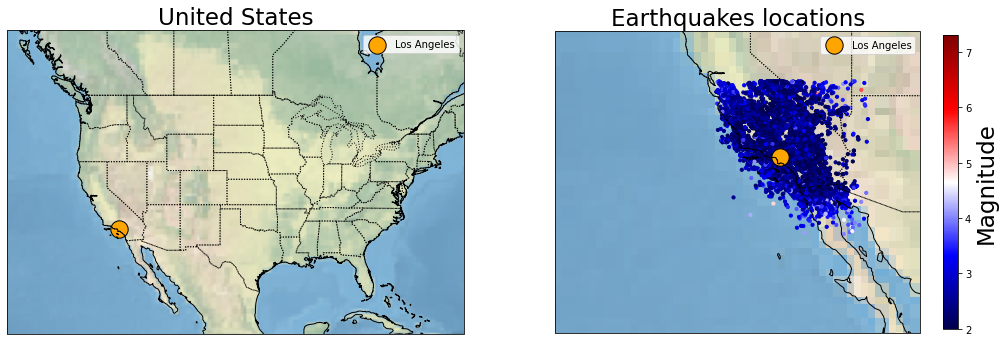

In [48]:
#los angeles coordinate, just for comparison
los_angeles_longitude = -118.243683
los_angeles_latitude = 34.052235

fig = plt.figure(figsize=(18,18))

ax0 = fig.add_subplot(1,2,1, projection=crs.Mercator())
ax0.stock_img()
ax0.add_feature(cfeature.COASTLINE)
ax0.add_feature(cfeature.STATES, linestyle=':')
ax0.add_feature(cfeature.BORDERS, linestyle=':')
ax0.set_extent([-135, -66.5, 20, 55], crs=crs.PlateCarree())   #setting the window to visualize USA
ax0.set_title("United States", fontsize=23)
ax0.scatter(los_angeles_longitude, los_angeles_latitude, s=300, c='orange', edgecolor='black', 
            label='Los Angeles', transform=crs.PlateCarree())
ax0.legend()

ax1 = fig.add_subplot(1,2,2, projection=crs.Mercator())
ax1.stock_img()
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.STATES, linestyle=':')
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.set_extent([-131.5, -110, 25, 40], crs=crs.PlateCarree())   #setting the window to visualize California
ax1.set_title("Earthquakes locations", fontsize=23)

locations = ax1.scatter(df_complete['Longitude'], df_complete['Latitude'], s=10, c=df_complete['Magnitude'],
            cmap='seismic', transform=crs.PlateCarree())
ax1.scatter(los_angeles_longitude, los_angeles_latitude, s=300, c='orange', edgecolor='black',
            label='Los Angeles', transform=crs.PlateCarree())
cb = fig.colorbar(locations, shrink=0.3)
cb.set_label(label='Magnitude', size=23)
ax1.legend()

plt.show()